In [67]:
#Importanto Bibliotecas
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
import glob
import re
from functools import reduce
from datetime import datetime
import locale
pd.set_option('display.max_columns', None)

In [68]:
locale.setlocale(locale.LC_ALL, 'pt_pt.UTF-8')

'pt_pt.UTF-8'

In [69]:
# Listando as bases
lista_de_bases = glob.glob("bases/*.csv")
lista_de_bases

['bases\\STP-20240227161120920-Indicadores_da_produção.csv',
 'bases\\STP-20240227161907632-PIB_MENSAL.csv',
 'bases\\STP-20240227162913656-IPCA.csv']

In [70]:
#Carregando bases
bases = []
for base_name in lista_de_bases:
    df_base = pd.read_csv(base_name, sep = ';', encoding='ANSI', decimal=',')
    bases.append(df_base)

In [71]:
#Juantando bases horizontalmente
df = reduce(lambda a, b : pd.merge(left = a, right = b, how = 'inner', on = ['Data']), bases)
df = df.loc[df['Data'] != 'Fonte']
df

,Data,21859 - Indicadores da produção (2022=100) - Geral - Índice,21861 - Indicadores da produção (2022=100) - Extrativa mineral - Índice,21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice,21863 - Indicadores da produção (2022=100) - Bens de capital - Índice,21864 - Indicadores da produção (2022=100) - Bens intermediários - Índice,21865 - Indicadores da produção (2022=100) - Bens de consumo - Índice,21866 - Indicadores da produção (2022=100) - Bens de consumo duráveis - Índice,21867 - Indicadores da produção (2022=100) - Semiduráveis e não duráveis - Índice,21868 - Indicadores da produção (2022=100) - Insumos da construção civil - Índice,4380 - PIB mensal - Valores correntes (R$ milhões) - R$ (milhões),11752 - Índice da taxa de câmbio real efetiva (IPCA) - Jun/1994=100 - Índice,11753 - Índice da taxa de câmbio real (IPCA) - Jun/1994=100 - Dólar americano - Índice,20360 - Índice da taxa de câmbio efetiva nominal - Jun/1994=100 - Índice
0,jan/02,"84,40","72,30","85,10","58,20","88,00","86,30","79,80","87,70",-,"112374,80","111,75","133,88","193,74"
1,fev/02,"81,20","68,30","82,10","56,80","85,20","82,10","77,00","83,10",-,"111477,10","111,03","136,27","188,11"
2,mar/02,"90,20","78,50","91,00","64,70","94,90","90,00","91,00","89,70",-,"118444,70","106,76","132,12","178,46"
3,abr/02,"92,80","77,10","93,80","68,90","96,00","94,60","101,80","92,80",-,"120385,90","105,39","130,33","173,20"
4,mai/02,"93,70","79,00","94,70","66,70","99,10","93,00","92,60","92,90",-,"123552,50","112,89","139,02","183,61"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,jun/23,"102,00","109,10","100,80","91,90","103,10","102,00","94,50","103,10","100,30","895664,20","117,47","128,82","228,62"
258,jul/23,"105,80","113,10","104,60","86,30","106,60","108,00","95,10","110,10","103,60","912717,40","118,04","127,49","225,49"
259,ago/23,"111,30","110,00","111,50","97,70","109,00","118,30","119,20","118,10","107,70","923779,80","119,48","130,49","225,06"
260,set/23,"106,20","114,90","104,80","89,40","105,40","111,30","108,80","111,70","99,30","904464,20","118,73","131,41","223,25"


In [72]:
df['Data'] = df['Data'].apply(lambda x : datetime.strptime(x, '%b/%y'))

In [73]:
df.describe()

<ipython-input-73-ea8415b8a3ee>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe()


,Data,21859 - Indicadores da produção (2022=100) - Geral - Índice,21861 - Indicadores da produção (2022=100) - Extrativa mineral - Índice,21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice,21863 - Indicadores da produção (2022=100) - Bens de capital - Índice,21864 - Indicadores da produção (2022=100) - Bens intermediários - Índice,21865 - Indicadores da produção (2022=100) - Bens de consumo - Índice,21866 - Indicadores da produção (2022=100) - Bens de consumo duráveis - Índice,21867 - Indicadores da produção (2022=100) - Semiduráveis e não duráveis - Índice,21868 - Indicadores da produção (2022=100) - Insumos da construção civil - Índice,4380 - PIB mensal - Valores correntes (R$ milhões) - R$ (milhões),11752 - Índice da taxa de câmbio real efetiva (IPCA) - Jun/1994=100 - Índice,11753 - Índice da taxa de câmbio real (IPCA) - Jun/1994=100 - Dólar americano - Índice,20360 - Índice da taxa de câmbio efetiva nominal - Jun/1994=100 - Índice
count,262,262,262,262,262,262,262,262,262,262,262,262,262,262
unique,262,200,199,194,217,185,198,228,202,125,262,257,260,262
top,2009-09-01 00:00:00,"101,40","120,80","106,10","102,10","105,40","105,30","98,50","106,20",-,"140147,50","87,63","72,56","160,01"
freq,1,3,5,5,4,5,5,3,6,120,1,2,2,1
first,2002-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2023-10-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
df.isnull().any()

Data                                                                                      False
21859 - Indicadores da produção (2022=100) - Geral - Índice                               False
21861 - Indicadores da produção (2022=100) - Extrativa mineral - Índice                   False
21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice          False
21863 - Indicadores da produção (2022=100) - Bens de capital - Índice                     False
21864 - Indicadores da produção (2022=100) - Bens intermediários - Índice                 False
21865 - Indicadores da produção (2022=100) - Bens de consumo - Índice                     False
21866 - Indicadores da produção (2022=100) - Bens de consumo duráveis - Índice            False
21867 - Indicadores da produção (2022=100) - Semiduráveis e não duráveis - Índice         False
21868 - Indicadores da produção (2022=100) - Insumos da construção civil - Índice         False
4380 - PIB mensal - Valores correntes (R

In [75]:
for col in df.columns[1:]:
    df[col] = df[col].apply(lambda x : x.strip().replace(',', '.')).replace('-',np.NaN).astype(float)

In [76]:
#Média Móvel Simples
df['6-month-SMA'] = df['21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice'].rolling(window=6).mean()
df['12-month-SMA'] = df['21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice'].rolling(window=12).mean()
df

,Data,21859 - Indicadores da produção (2022=100) - Geral - Índice,21861 - Indicadores da produção (2022=100) - Extrativa mineral - Índice,21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice,21863 - Indicadores da produção (2022=100) - Bens de capital - Índice,21864 - Indicadores da produção (2022=100) - Bens intermediários - Índice,21865 - Indicadores da produção (2022=100) - Bens de consumo - Índice,21866 - Indicadores da produção (2022=100) - Bens de consumo duráveis - Índice,21867 - Indicadores da produção (2022=100) - Semiduráveis e não duráveis - Índice,21868 - Indicadores da produção (2022=100) - Insumos da construção civil - Índice,4380 - PIB mensal - Valores correntes (R$ milhões) - R$ (milhões),11752 - Índice da taxa de câmbio real efetiva (IPCA) - Jun/1994=100 - Índice,11753 - Índice da taxa de câmbio real (IPCA) - Jun/1994=100 - Dólar americano - Índice,20360 - Índice da taxa de câmbio efetiva nominal - Jun/1994=100 - Índice,6-month-SMA,12-month-SMA
0,2002-01-01,84.4,72.3,85.1,58.2,88.0,86.3,79.8,87.7,NaN,112374.8,111.75,133.88,193.74,NaN,NaN
1,2002-02-01,81.2,68.3,82.1,56.8,85.2,82.1,77.0,83.1,NaN,111477.1,111.03,136.27,188.11,NaN,NaN
2,2002-03-01,90.2,78.5,91.0,64.7,94.9,90.0,91.0,89.7,NaN,118444.7,106.76,132.12,178.46,NaN,NaN
3,2002-04-01,92.8,77.1,93.8,68.9,96.0,94.6,101.8,92.8,NaN,120385.9,105.39,130.33,173.20,NaN,NaN
4,2002-05-01,93.7,79.0,94.7,66.7,99.1,93.0,92.6,92.9,NaN,123552.5,112.89,139.02,183.61,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,2023-06-01,102.0,109.1,100.8,91.9,103.1,102.0,94.5,103.1,100.3,895664.2,117.47,128.82,228.62,95.216667,99.383333
258,2023-07-01,105.8,113.1,104.6,86.3,106.6,108.0,95.1,110.1,103.6,912717.4,118.04,127.49,225.49,97.800000,99.150000
259,2023-08-01,111.3,110.0,111.5,97.7,109.0,118.3,119.2,118.1,107.7,923779.8,119.48,130.49,225.06,101.916667,99.158333
260,2023-09-01,106.2,114.9,104.8,89.4,105.4,111.3,108.8,111.7,99.3,904464.2,118.73,131.41,223.25,102.850000,99.091667


<AxesSubplot:xlabel='Data'>

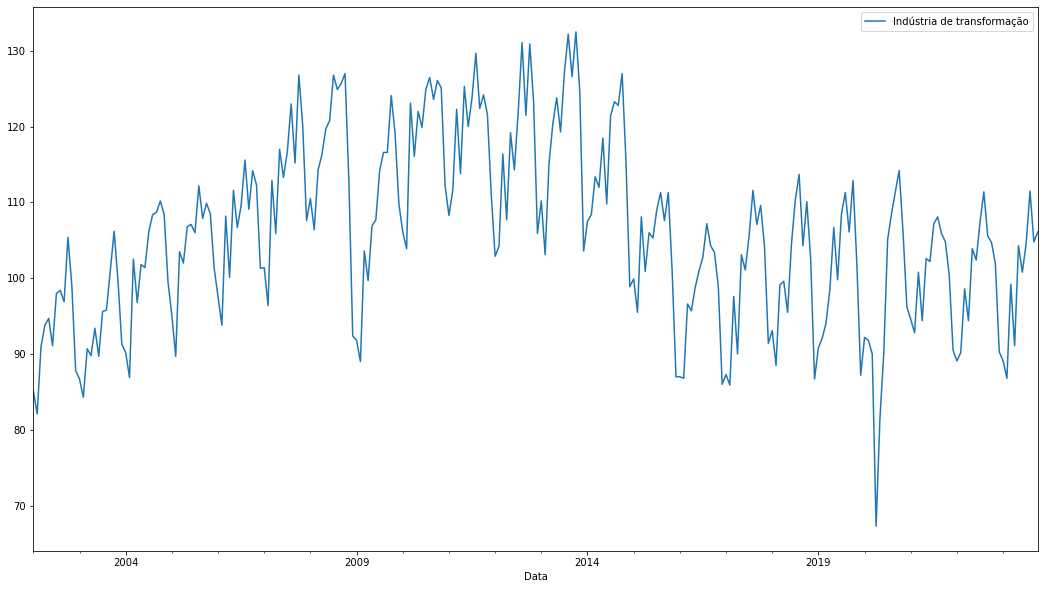

In [77]:
df_ind_transf = df.set_index('Data')[['21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice']].copy()
df_ind_transf.rename(columns={'21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice':'Indústria de transformação'}, inplace=True)
df_ind_transf.plot(figsize=(18,10))

In [78]:
df_ind_transf.head(2)

,Indústria de transformação
Data,
2002-01-01,85.1
2002-02-01,82.1


In [79]:
dfSMA = df.set_index('Data')[['21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice', '6-month-SMA', '12-month-SMA']].copy()
dfSMA.rename(columns={'21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice':'Indústria de transformação'}, inplace=True)
dfSMA

,Indústria de transformação,6-month-SMA,12-month-SMA
Data,,,
2002-01-01,85.1,NaN,NaN
2002-02-01,82.1,NaN,NaN
2002-03-01,91.0,NaN,NaN
2002-04-01,93.8,NaN,NaN
2002-05-01,94.7,NaN,NaN
...,...,...,...
2023-06-01,100.8,95.216667,99.383333
2023-07-01,104.6,97.800000,99.150000
2023-08-01,111.5,101.916667,99.158333


<AxesSubplot:xlabel='Data'>

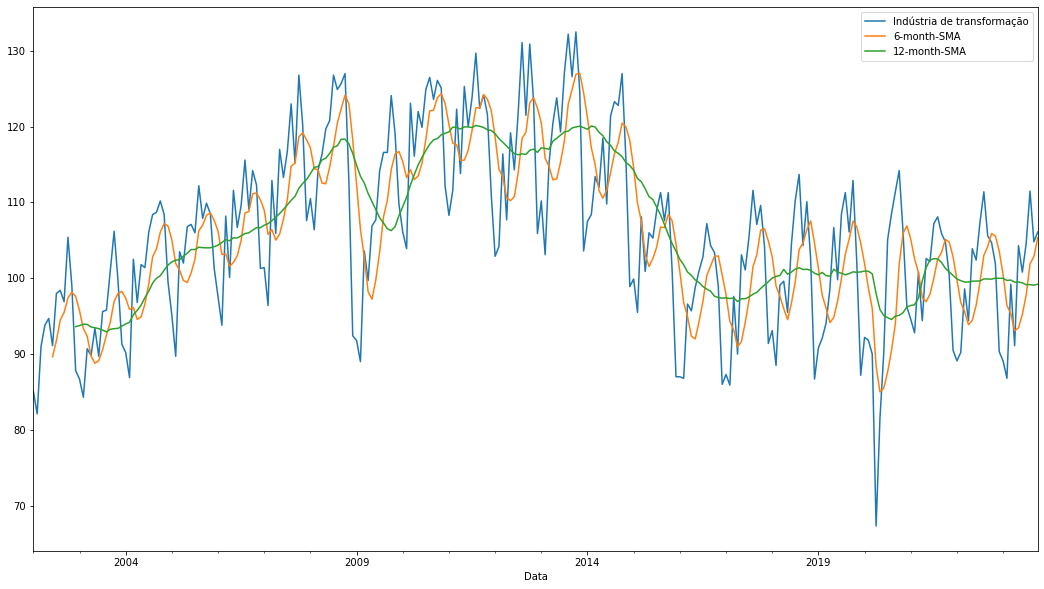

In [80]:
dfSMA.plot(figsize=(18,10))

In [81]:
#Média Móvel Exponencialmente Ponderada
df['6-month-EWMA'] = df['21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice'].ewm(span=6,adjust=False).mean()
df['12-month-EWMA'] = df['21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice'].ewm(span=12,adjust=False).mean()
df

,Data,21859 - Indicadores da produção (2022=100) - Geral - Índice,21861 - Indicadores da produção (2022=100) - Extrativa mineral - Índice,21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice,21863 - Indicadores da produção (2022=100) - Bens de capital - Índice,21864 - Indicadores da produção (2022=100) - Bens intermediários - Índice,21865 - Indicadores da produção (2022=100) - Bens de consumo - Índice,21866 - Indicadores da produção (2022=100) - Bens de consumo duráveis - Índice,21867 - Indicadores da produção (2022=100) - Semiduráveis e não duráveis - Índice,21868 - Indicadores da produção (2022=100) - Insumos da construção civil - Índice,4380 - PIB mensal - Valores correntes (R$ milhões) - R$ (milhões),11752 - Índice da taxa de câmbio real efetiva (IPCA) - Jun/1994=100 - Índice,11753 - Índice da taxa de câmbio real (IPCA) - Jun/1994=100 - Dólar americano - Índice,20360 - Índice da taxa de câmbio efetiva nominal - Jun/1994=100 - Índice,6-month-SMA,12-month-SMA,6-month-EWMA,12-month-EWMA
0,2002-01-01,84.4,72.3,85.1,58.2,88.0,86.3,79.8,87.7,NaN,112374.8,111.75,133.88,193.74,NaN,NaN,85.100000,85.100000
1,2002-02-01,81.2,68.3,82.1,56.8,85.2,82.1,77.0,83.1,NaN,111477.1,111.03,136.27,188.11,NaN,NaN,84.242857,84.638462
2,2002-03-01,90.2,78.5,91.0,64.7,94.9,90.0,91.0,89.7,NaN,118444.7,106.76,132.12,178.46,NaN,NaN,86.173469,85.617160
3,2002-04-01,92.8,77.1,93.8,68.9,96.0,94.6,101.8,92.8,NaN,120385.9,105.39,130.33,173.20,NaN,NaN,88.352478,86.876058
4,2002-05-01,93.7,79.0,94.7,66.7,99.1,93.0,92.6,92.9,NaN,123552.5,112.89,139.02,183.61,NaN,NaN,90.166056,88.079742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,2023-06-01,102.0,109.1,100.8,91.9,103.1,102.0,94.5,103.1,100.3,895664.2,117.47,128.82,228.62,95.216667,99.383333,98.166627,98.138794
258,2023-07-01,105.8,113.1,104.6,86.3,106.6,108.0,95.1,110.1,103.6,912717.4,118.04,127.49,225.49,97.800000,99.150000,100.004733,99.132826
259,2023-08-01,111.3,110.0,111.5,97.7,109.0,118.3,119.2,118.1,107.7,923779.8,119.48,130.49,225.06,101.916667,99.158333,103.289095,101.035468
260,2023-09-01,106.2,114.9,104.8,89.4,105.4,111.3,108.8,111.7,99.3,904464.2,118.73,131.41,223.25,102.850000,99.091667,103.720782,101.614627


In [82]:
dfEWMA = df.set_index('Data')[['21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice', '6-month-SMA', '12-month-SMA']].copy()
dfEWMA.rename(columns={'21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice':'Indústria de transformação'}, inplace=True)
dfEWMA

,Indústria de transformação,6-month-SMA,12-month-SMA
Data,,,
2002-01-01,85.1,NaN,NaN
2002-02-01,82.1,NaN,NaN
2002-03-01,91.0,NaN,NaN
2002-04-01,93.8,NaN,NaN
2002-05-01,94.7,NaN,NaN
...,...,...,...
2023-06-01,100.8,95.216667,99.383333
2023-07-01,104.6,97.800000,99.150000
2023-08-01,111.5,101.916667,99.158333


<AxesSubplot:xlabel='Data'>

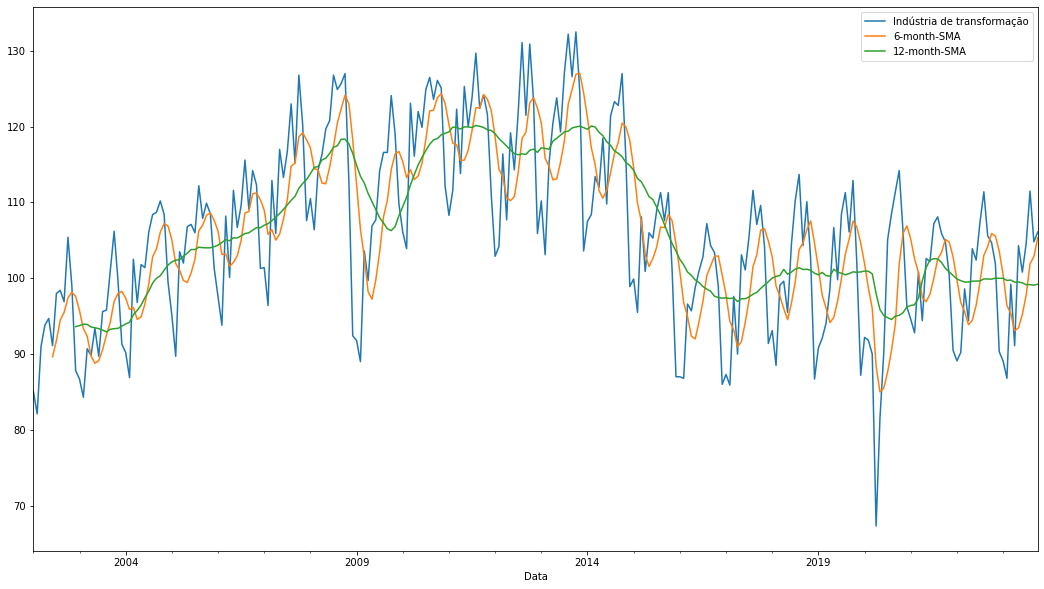

In [83]:
dfEWMA.plot(figsize=(18,10))

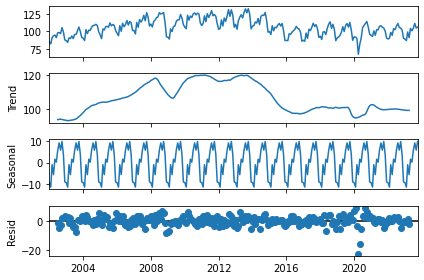

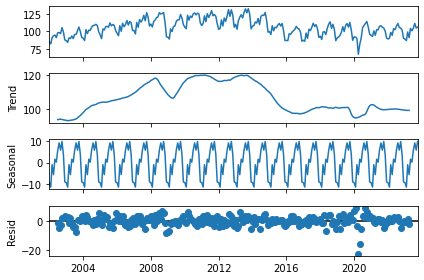

In [84]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decompose(df_ind_transf,model='add').plot()



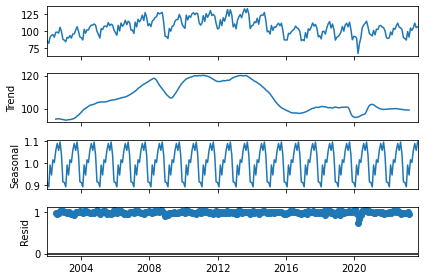

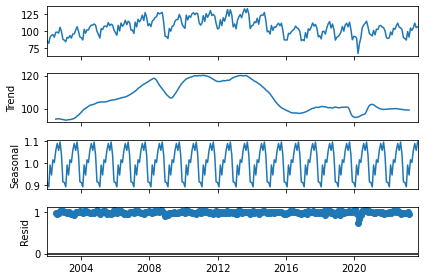

In [85]:
seasonal_decompose(df_ind_transf,model='mul').plot()

Modelo 1: ETS - Suavização Exponencial Tripla

In [86]:
len(df_ind_transf)

262

In [87]:
dados_treinados = df_ind_transf.iloc[:210]  # Primeiras 80% das linhas (262 * 0.8 = 209,6)
dados_testados= df_ind_transf.iloc[210:]   # Últimos 20% das linhas (262 - 210 = 52)


In [88]:
#Criando o modelo de Suavização Exponencial Tripla
from statsmodels.tsa.holtwinters import ExponentialSmoothing


In [89]:
fitted_model = ExponentialSmoothing(dados_treinados['Indústria de transformação'],trend='mul',seasonal='mul',seasonal_periods=12).fit()

c:\Users\bianc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\bianc\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


In [90]:
etsprevi = fitted_model.forecast(68).rename('ETS Previsão')
etsprevi

2019-07-01    105.989757
2019-08-01    109.427240
2019-09-01    105.990774
2019-10-01    110.265483
2019-11-01    104.590861
                 ...    
2024-10-01    111.377728
2024-11-01    105.645866
2024-12-01     93.201994
2025-01-01     92.806223
2025-02-01     90.590536
Freq: MS, Name: ETS Previsão, Length: 68, dtype: float64

<AxesSubplot:xlabel='Data'>

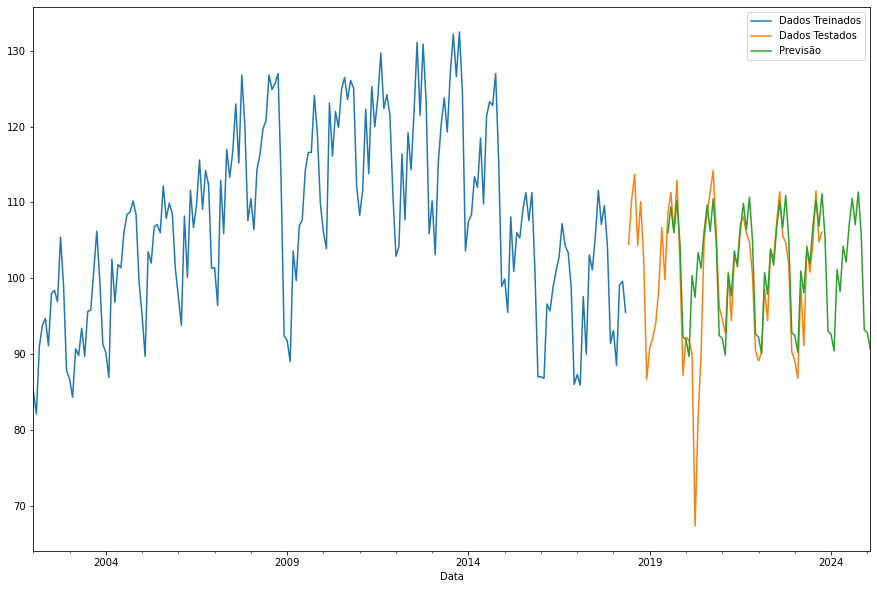

In [91]:
df_ind_transf.iloc[:197]['Indústria de transformação'].plot(legend=True, label='Dados Treinados')
df_ind_transf.iloc[197:]['Indústria de transformação'].plot(legend=True, label='Dados Testados', figsize=(15,10))
etsprevi.plot(legend=True, label='Previsão')

Modelo 2: SARIMA - Médias Móveis Integradas Autoregressivas Sazonais

In [92]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose      
                             